## EDA

This notebook covers initial exploratory analysis for the data related to clustering.



In [57]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [58]:
cwd = os.getcwd()
RAW_DATA_DIR = os.path.join(cwd, '..', 'data', 'raw')

In [59]:
def load_data():
    """Load all required CSV files"""
    consumptions = pd.read_csv(os.path.join(RAW_DATA_DIR,'customers_consumptions.csv'))
    metadata = pd.read_csv(os.path.join(RAW_DATA_DIR,'customers_metadata.csv'))
    weather = pd.read_csv(os.path.join(RAW_DATA_DIR,'weather_data.csv'))
    prices = pd.read_csv(os.path.join(RAW_DATA_DIR,'price_data.csv'))
    
    # Convert timestamp columns to datetime
    consumptions['validfrom'] = pd.to_datetime(consumptions['validfrom'])
    weather['validfrom'] = pd.to_datetime(weather['validfrom'])
    prices['timestamp'] = pd.to_datetime(prices['validfrom'])
    
    # sort outputs
    consumptions = consumptions.sort_values(by=["meteringpoint_id", "validfrom"])
    weather = weather.sort_values(by=["weatherstation_id", "validfrom"])
    
    return consumptions, metadata, weather, prices

In [60]:
consumptions_df, metadata_df, weather_df, prices_df = load_data()

In [61]:
consumptions_df

,meteringpoint_id,validfrom,quantity
4,261b7930-dd7e-43f0-8a42-4f31d97f9edb,2024-01-01 00:00:00+00:00,0.156
14,261b7930-dd7e-43f0-8a42-4f31d97f9edb,2024-01-01 00:15:00+00:00,0.306
22,261b7930-dd7e-43f0-8a42-4f31d97f9edb,2024-01-01 00:30:00+00:00,0.211
28,261b7930-dd7e-43f0-8a42-4f31d97f9edb,2024-01-01 00:45:00+00:00,0.184
36,261b7930-dd7e-43f0-8a42-4f31d97f9edb,2024-01-01 01:00:00+00:00,0.523
...,...,...,...
444067,eba9a77e-589f-4c63-b7d2-8506c0cb8a59,2024-10-31 22:45:00+00:00,0.002
444089,eba9a77e-589f-4c63-b7d2-8506c0cb8a59,2024-10-31 23:00:00+00:00,0.001
444108,eba9a77e-589f-4c63-b7d2-8506c0cb8a59,2024-10-31 23:15:00+00:00,0.002
444134,eba9a77e-589f-4c63-b7d2-8506c0cb8a59,2024-10-31 23:30:00+00:00,0.001


In [62]:
metadata_df.head()

,meteringpoint_id,weatherstation_id
0,261b7930-dd7e-43f0-8a42-4f31d97f9edb,8e35e073-450e-4a74-ba6f-368caf10fab2
1,32d6224d-820c-40be-9717-2b3ecf374ec3,a2d5f777-f4f1-460c-8dc8-c90dff944d4c
2,41ee7d78-7af0-438b-a1b2-247ec2a657fb,6ef7f78e-f1c7-4c40-8f7e-3e331e838d21
3,420d4f05-b0e2-43a3-90ff-c6c59a096dd2,d8935f16-ddc1-4612-8fd0-0f968e1e3cf1
4,6693d5ac-7a00-479f-83d4-5a4c14aaca4e,2fa1da9a-2984-483a-a4d0-2fecc570df68


In [63]:
weather_df.head()

,validfrom,weatherstation_id,air_temp,ghi,cloud_opacity,precipitable_water
5,2024-01-01 00:00:00+00:00,01329c85-98ea-4bf6-b765-0331d23e8008,4,0,74.4,15.1
29,2024-01-01 00:15:00+00:00,01329c85-98ea-4bf6-b765-0331d23e8008,4,0,68.8,15.2
42,2024-01-01 00:30:00+00:00,01329c85-98ea-4bf6-b765-0331d23e8008,4,0,70.7,15.3
48,2024-01-01 00:45:00+00:00,01329c85-98ea-4bf6-b765-0331d23e8008,4,0,72.8,15.4
65,2024-01-01 01:00:00+00:00,01329c85-98ea-4bf6-b765-0331d23e8008,4,0,68.9,15.4


In [64]:
prices_df.head()

,validfrom,price,timestamp
0,2024-01-01 00:00:00+00:00,0.01,2024-01-01 00:00:00+00:00
1,2024-01-01 01:00:00+00:00,0.02,2024-01-01 01:00:00+00:00
2,2024-01-01 02:00:00+00:00,0.00,2024-01-01 02:00:00+00:00
3,2024-01-01 03:00:00+00:00,-0.01,2024-01-01 03:00:00+00:00
4,2024-01-01 04:00:00+00:00,-0.01,2024-01-01 04:00:00+00:00


In [65]:
def preprocess_consumptions(consumptions):
    
    # Split out time
    consumptions['hour'] = consumptions['validfrom'].dt.hour
    consumptions['day_of_week'] = consumptions['validfrom'].dt.dayofweek
    consumptions['month'] = consumptions['validfrom'].dt.month
    consumptions['date'] = consumptions['validfrom'].dt.date
    
    print(f"Null values in consumption data:\n{consumptions.isnull().sum()}")
    
    # Group by meteringpoint_id and calculate statistics
    customer_stats = (
        consumptions
        .groupby('meteringpoint_id')
        .agg({
            'date': 'nunique',
            'quantity': ['mean', 'std', 'min', 'max', 'count']
        })
        .round(3)
    )
    
    customer_stats.columns = [
        'days_count', 
        'avg_consumption',
        'std_consumption',
        'min_consumption',
        'max_consumption',
        'measurements_count'
    ]
    
    customer_stats = customer_stats.reset_index()
    
    # Print summary statistics
    print("\nCustomer Statistics Summary:")
    print(f"Total number of customers: {len(customer_stats)}")
    print(f"Average days per customer: {customer_stats['days_count'].mean():.1f}")
    print(f"Min days for a customer: {customer_stats['days_count'].min()}")
    print(f"Max days for a customer: {customer_stats['days_count'].max()}")
    
    return consumptions, customer_stats

In [66]:
consumptions_df, stats = preprocess_consumptions(consumptions_df)

Null values in consumption data:
meteringpoint_id    0
validfrom           0
quantity            0
hour                0
day_of_week         0
month               0
date                0
dtype: int64

Customer Statistics Summary:
Total number of customers: 20
Average days per customer: 231.8
Min days for a customer: 32
Max days for a customer: 305


In [75]:
def check_time_continuity(df, meteringpoint_id=None, granularity_minutes=15):
    """
    Check if the time series is continuous between min and max timestamps using pandas optimizations.
    """

    if meteringpoint_id is not None:
        df = df[df['meteringpoint_id'] == meteringpoint_id]

    # Group by meteringpoint_id and calculate stats
    meter_stats = df.groupby('meteringpoint_id').agg({
        'validfrom': ['min', 'max', 'count']
    }).reset_index()
    
    meter_stats.columns = ['meteringpoint_id', 'min_time', 'max_time', 'actual_readings']
    
    results = {}
    for _, row in meter_stats.iterrows():
        # Create complete timestamp range
        full_range = pd.DataFrame({
            'validfrom': pd.date_range(
                start=row['min_time'],
                end=row['max_time'],
                freq=f'{granularity_minutes}T'
            )
        })
        
        actual_data = df[df['meteringpoint_id'] == row['meteringpoint_id']]
        
        missing_timestamps = full_range[~full_range['validfrom'].isin(actual_data['validfrom'])]
        
        expected_readings = len(full_range)
        actual_readings = row['actual_readings']
        
        results[row['meteringpoint_id']] = {
            'min_time': row['min_time'],
            'max_time': row['max_time'],
            'expected_readings': expected_readings,
            'actual_readings': actual_readings,
            'missing_readings': expected_readings - actual_readings,
            'is_continuous': len(missing_timestamps) == 0,
            'missing_timestamps': missing_timestamps['validfrom'].tolist(),
            'completeness_ratio': actual_readings / expected_readings
        }
        
        # Print summary
        print(f"\nMeter: {row['meteringpoint_id']}")
        print(f"Time range: {row['min_time']} to {row['max_time']}")
        print(f"Expected readings: {expected_readings}")
        print(f"Actual readings: {actual_readings}")
        print(f"Missing readings: {expected_readings - actual_readings}")
        print(f"Completeness ratio: {(actual_readings / expected_readings):.2%}")
        
        if len(missing_timestamps) > 0:
            print(f"First few missing timestamps: {missing_timestamps['validfrom'].head().tolist()}")
    
    return results

In [83]:
results = check_time_continuity(consumptions_df)


Meter: 261b7930-dd7e-43f0-8a42-4f31d97f9edb
Time range: 2024-01-01 00:00:00+00:00 to 2024-10-31 23:45:00+00:00
Expected readings: 29280
Actual readings: 29280
Missing readings: 0
Completeness ratio: 100.00%

Meter: 32d6224d-820c-40be-9717-2b3ecf374ec3
Time range: 2024-09-30 22:00:00+00:00 to 2024-10-31 23:45:00+00:00
Expected readings: 2984
Actual readings: 2984
Missing readings: 0
Completeness ratio: 100.00%

Meter: 41ee7d78-7af0-438b-a1b2-247ec2a657fb
Time range: 2024-01-01 00:00:00+00:00 to 2024-10-31 22:45:00+00:00
Expected readings: 29276
Actual readings: 29276
Missing readings: 0
Completeness ratio: 100.00%

Meter: 420d4f05-b0e2-43a3-90ff-c6c59a096dd2
Time range: 2024-01-01 00:00:00+00:00 to 2024-10-31 23:45:00+00:00
Expected readings: 29280
Actual readings: 29280
Missing readings: 0
Completeness ratio: 100.00%

Meter: 6693d5ac-7a00-479f-83d4-5a4c14aaca4e
Time range: 2024-03-10 23:00:00+00:00 to 2024-10-31 23:45:00+00:00
Expected readings: 22564
Actual readings: 22564
Missing re

In [ ]:
def plot_meter_timeseries(consumptions, height_per_meter=2.5, width=20):
    """
    Plot consumption timeseries for each meteringpoint_id with dynamic figure sizing.
    
    Args:
        consumptions (pd.DataFrame): DataFrame with columns ['meteringpoint_id', 'validfrom', 'quantity']
        height_per_meter (float): Height in inches to allocate for each meter's plot
        width (int): Width of the figure in inches
    """
    # Sort by time
    consumptions = consumptions.sort_values('validfrom')
    
    # Get number of unique meters
    meter_ids = consumptions['meteringpoint_id'].unique()
    n_meters = len(meter_ids)
    
    # Calculate total height needed
    total_height = n_meters * height_per_meter
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_meters, 1, figsize=(width, total_height))
    if n_meters == 1:
        axes = [axes]  # Make it iterable for single plot case
    
    print(f"Plotting {n_meters} meters with figure size: {width}x{total_height} inches")
    
    for ax, meter_id in zip(axes, meter_ids):
        # Get data for this meter
        meter_data = consumptions[consumptions['meteringpoint_id'] == meter_id]
        
        # Plot
        ax.plot(meter_data['validfrom'], meter_data['quantity'], linewidth=1)
        
        # Customize plot
        ax.set_title(f'Meter ID: {meter_id}')
        ax.grid(True, alpha=0.3)
        
        # Format y-axis to show values in kWh
        ax.set_ylabel('kWh')
        
        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)
        
        # Add basic statistics
        stats_text = (f'Mean: {meter_data["quantity"].mean():.2f} kWh\n'
                     f'Max: {meter_data["quantity"].max():.2f} kWh')
        ax.text(0.02, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add overall title
    fig.suptitle('Consumption Patterns for All Meters', fontsize=14, y=1.0)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
    plt.show()

Plotting 20 meters with figure size: 20x100 inches


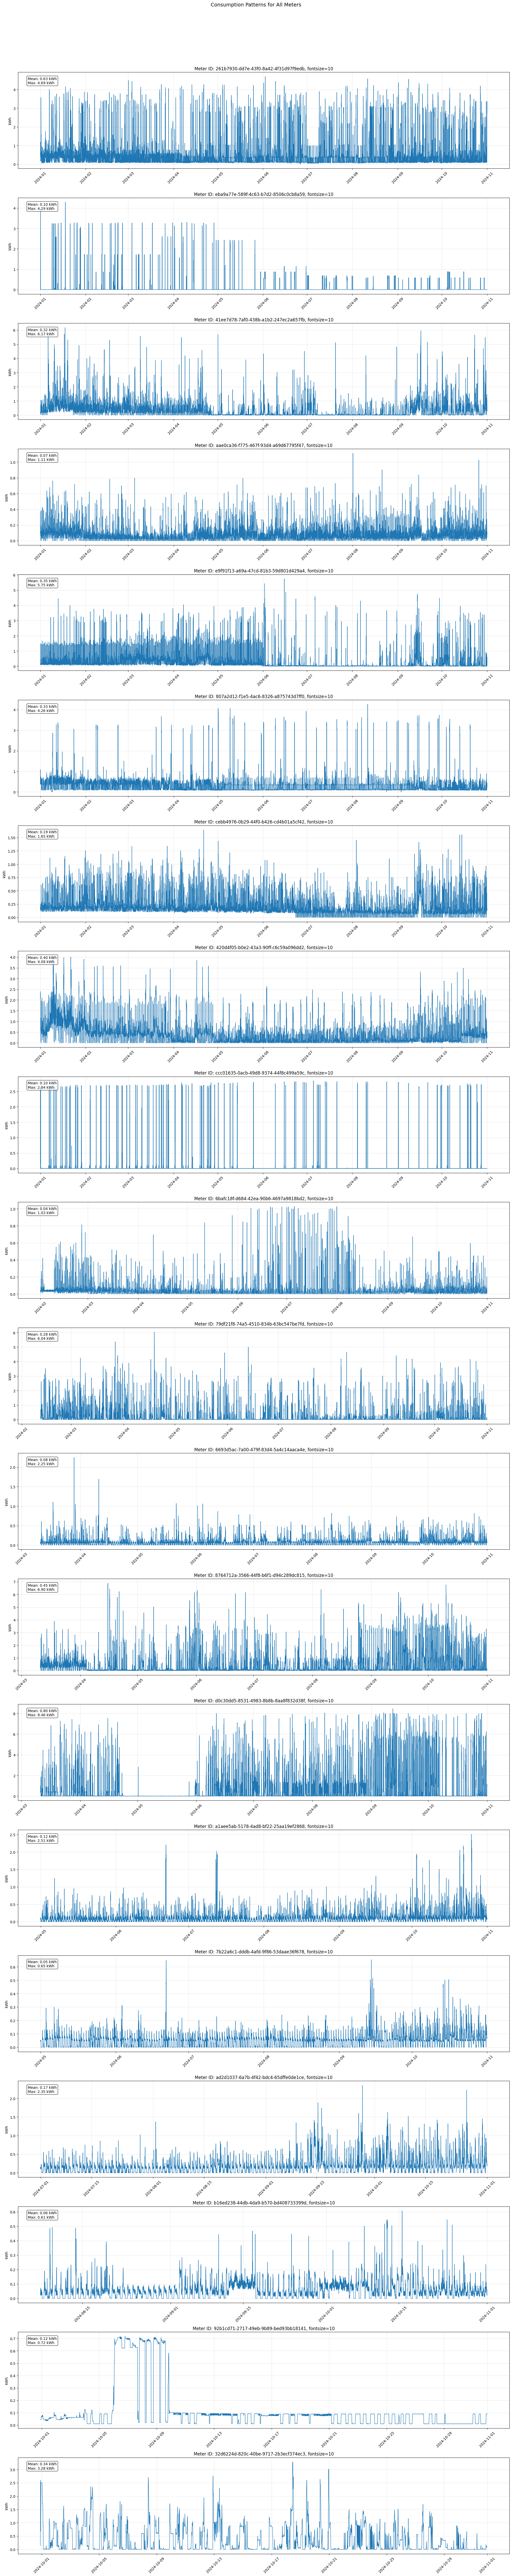

In [117]:
plot_meter_timeseries(consumptions_df, height_per_meter=5)